# Data

In [22]:
import numpy as np

dim =50    #矩阵维度

# 设置高斯分布的参数
mean = np.zeros(dim)  # dim维的均值向量
cov = np.eye(dim)     # dim维的协方差矩阵（单位矩阵）

# 生成num_samples个dim维的高斯分布样本
np.random.seed(42)
num_samples = 1000
data = np.random.multivariate_normal(mean, cov, num_samples)

r=0.1
C = np.zeros([dim,dim])
for i in range(dim):
    for j in range(dim):
        C[i,j]=r**abs(i-j)

data = data@(C**0.5)

np.random.seed(43)
data_eval = np.random.multivariate_normal(mean, cov, num_samples)@(C**0.5)
print(data.shape)

# 计算样本协方差矩阵
SCM = data_eval.T@data_eval/num_samples
print(SCM)

(1000, 50)
[[ 1.11839729  0.65415741  0.31577911 ... -0.04580904 -0.02284918
  -0.02326654]
 [ 0.65415741  1.17280328  0.66707113 ... -0.03282527 -0.0087385
   0.02163007]
 [ 0.31577911  0.66707113  1.25915867 ...  0.00516014  0.02455199
   0.03869028]
 ...
 [-0.04580904 -0.03282527  0.00516014 ...  1.26312615  0.723838
   0.34985474]
 [-0.02284918 -0.0087385   0.02455199 ...  0.723838    1.23549596
   0.71353933]
 [-0.02326654  0.02163007  0.03869028 ...  0.34985474  0.71353933
   1.14842126]]


In [23]:
# 极端测试数据
import numpy as np

# 设置第一列全为100
data[:, 0] = 10
# 设置第二列全为50
data[:, 1] = 2
# 设置第三列全为25
data[:, 2] = 1

# 设置第一列全为100
data_eval[:, 0] = 10
# 设置第二列全为50
data_eval[:, 1] = 2
# 设置第三列全为25
data_eval[:, 2] = 1

# Transformer model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, n, m, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(m, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_encoder_layers)
        self.fc = nn.Linear(d_model, m)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)

        # 调整形状，添加批量和通道维度
        x = x.unsqueeze(0).unsqueeze(0)  # 变为 [1, 1, 400, 256]

        # 定义卷积层（假设卷积层的配置可以将输入转换为 [1, 1, 1, 50]）
        conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 8), stride=(8, 8))

        # 通过卷积层
        x_conv = conv(x)  # 形状会是 [1, 1, 1, 50]

        # 定义池化层
        pool = nn.AdaptiveAvgPool2d((1, 50))

        # 通过池化层
        x_pooled = pool(x_conv)  # 形状会是 [1, 1, 1, 50]

        # 展平张量
        x_flattened = x_pooled.view(-1)  # 形状为 [50]

        w = x_flattened


        w = self.softmax(w)
        return w

def compute_loss(x, w):
    r = torch.matmul(x, w)
    r_mean = r.mean()
    loss = ((r - r_mean) ** 2).mean()  # 方差
    return loss

# 数据
n = 1000  # 天数
m = 50   # 股票数量
d_model = 256
nhead = 16
num_encoder_layers = 6

x = torch.from_numpy(data).float()

# 模型
model = TransformerModel(n, m, d_model, nhead, num_encoder_layers)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练
epochs = 100
k = 2  # 分割数量
s = int(n / k)  #  每份数量
train_ratio = 0.8
train_losses = []
best_train_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    total_train_loss = 0
    total_test_loss = 0
    for i in range(k):
        # 分割数据
        train_data = x[i*s:int(i*s+s*train_ratio)]
        test_data = x[int(i*s+s*train_ratio):i*s+s]

        model.train()
        optimizer.zero_grad()
        w = model(train_data)
        train_loss = compute_loss(test_data, w)
        train_loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # 计算测试损失
        model.eval()
        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / k
    train_losses.append(avg_train_loss)

    # 保存最佳模型
    if avg_train_loss < best_train_loss:
        best_test_loss = avg_train_loss
        best_model_state = model.state_dict().copy()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Avg Loss: {avg_train_loss}')

# 保存最佳模型状态
if best_model_state is not None:
    torch.save(best_model_state, 'best_model.pth')

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 训练结果
w1 = model(x[:80]).detach().numpy()
print("权重:", w1)

Epoch 0, Avg Loss: 0.08585094287991524
Epoch 10, Avg Loss: 0.12563658505678177
Epoch 20, Avg Loss: 0.056125020841136575
Epoch 30, Avg Loss: 0.07205747440457344
Epoch 40, Avg Loss: 0.06181707978248596
Epoch 50, Avg Loss: 0.0537824893835932
Epoch 60, Avg Loss: 0.04835698567330837
Epoch 70, Avg Loss: 0.08145556226372719
Epoch 80, Avg Loss: 0.04385393229313195
Epoch 90, Avg Loss: 0.06552311219274998
权重: [0.08505355 0.16292644 0.3120978  0.04312808 0.00633791 0.00674004
 0.00808092 0.00837758 0.00724398 0.00801212 0.00863179 0.00840784
 0.00873808 0.00908128 0.00963489 0.0088963  0.00774234 0.00820103
 0.00942401 0.01022368 0.01034249 0.00977692 0.00913612 0.00886116
 0.00859447 0.00840415 0.00963956 0.01105658 0.01071952 0.00847789
 0.00691586 0.00864073 0.00931613 0.00803926 0.00769272 0.00821604
 0.00917025 0.00898511 0.00880371 0.00858503 0.00845052 0.00853001
 0.0089406  0.00907254 0.00878362 0.00932571 0.00818038 0.00675859
 0.00743204 0.00817258]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, n, m, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(m, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_encoder_layers)
        self.fc = nn.Linear(d_model, m)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)

        # 对第一个维度进行总和池化
        x_pooled = x.mean(dim=0, keepdim=True)  # 形状为 [1, 256]

        # 展平张量
        x_flattened = x_pooled.view(-1)

        w = x_flattened
        w = self.fc(w)

        w = self.softmax(w)
        return w

def compute_loss(x, w):
    r = torch.matmul(x, w)
    r_mean = r.mean()
    loss = ((r - r_mean) ** 2).mean()  # 方差
    return loss

# 数据
n = 1000  # 天数
m = 50   # 股票数量
d_model = 256
nhead = 16
num_encoder_layers = 6

x = torch.from_numpy(data).float()

# 模型
model = TransformerModel(n, m, d_model, nhead, num_encoder_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练
epochs = 50
k = 2  # 分割数量
s = int(n / k)  #  每份数量
train_ratio = 0.8
train_losses = []
test_losses = []
for epoch in range(epochs):
    total_train_loss = 0
    total_test_loss = 0
    for i in range(k):
        # 分割数据
        train_data = x[i*s:int(i*s+s*train_ratio)]
        test_data = x[int(i*s+s*train_ratio):i*s+s]

        model.train()
        optimizer.zero_grad()
        w = model(train_data)
        train_loss = compute_loss(test_data, w)
        train_loss.backward()

        # # 梯度裁剪
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # 计算测试损失
        model.eval()
        with torch.no_grad():
            test_loss = compute_loss(test_data, w)

        total_train_loss += train_loss.item()
        total_test_loss += test_loss.item()

    avg_train_loss = total_train_loss / k
    avg_test_loss = total_test_loss / k
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    if epoch % 10 == 0:
        # print(f'Epoch {epoch}, Avg Train Loss: {avg_train_loss}, Avg Test Loss: {avg_test_loss}')
        print(f'Epoch {epoch}, Avg Loss: {avg_train_loss}')

# 训练结果
w1 = model(x[:80]).detach().numpy()
print("权重:", w1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Avg Loss: 0.07742051966488361
Epoch 10, Avg Loss: 0.04715517349541187
Epoch 20, Avg Loss: 0.045364366844296455
Epoch 30, Avg Loss: 0.045089688152074814
Epoch 40, Avg Loss: 0.04508536122739315
权重: [0.0003913  0.06298193 0.00039962 0.01033516 0.02397076 0.00415003
 0.04778616 0.01546109 0.04380285 0.00245997 0.05440901 0.02347195
 0.00863948 0.03638843 0.00096578 0.02632657 0.02040359 0.01540694
 0.00024891 0.01068855 0.01362725 0.04381124 0.00076357 0.0190735
 0.00109515 0.02320518 0.0048978  0.02892943 0.03743166 0.0014552
 0.03949156 0.00841932 0.00872704 0.01939523 0.01331497 0.04812453
 0.01249691 0.00344926 0.00435475 0.02003269 0.00076182 0.00036976
 0.05525166 0.00794913 0.01387063 0.00038492 0.07004527 0.01465359
 0.03224988 0.043679  ]


In [26]:
model.eval()
with torch.no_grad():
    w_tf = model(torch.from_numpy(data_eval).float())  # 计算新的权重
print(w_tf)

tensor([0.0077, 0.0068, 0.0060, 0.0123, 0.0240, 0.0229, 0.0201, 0.0189, 0.0202,
        0.0217, 0.0200, 0.0173, 0.0228, 0.0300, 0.0271, 0.0238, 0.0231, 0.0191,
        0.0152, 0.0147, 0.0147, 0.0182, 0.0224, 0.0249, 0.0275, 0.0250, 0.0229,
        0.0210, 0.0194, 0.0197, 0.0218, 0.0206, 0.0205, 0.0216, 0.0211, 0.0182,
        0.0161, 0.0158, 0.0155, 0.0155, 0.0164, 0.0174, 0.0183, 0.0184, 0.0175,
        0.0196, 0.0259, 0.0308, 0.0301, 0.0294])


# CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 生成数据
dim = 50    # 矩阵维度

# 设置高斯分布的参数
mean = np.zeros(dim)  # dim维的均值向量
cov = np.eye(dim)     # dim维的协方差矩阵（单位矩阵）

# 生成num_samples个dim维的高斯分布样本
num_samples = 1000
data = np.random.multivariate_normal(mean, cov, num_samples)

r = 0.1
C = np.zeros([dim, dim])
for i in range(dim):
    for j in range(dim):
        C[i, j] = r ** abs(i - j)

data = data @ (C ** 0.5)
data_eval = np.random.multivariate_normal(mean, cov, num_samples) @ (C ** 0.5)

class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.transpose(1, 2)  # 转换为 (batch_size, channels, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.mean(dim=2)  # 平均池化，得到 (batch_size, hidden_dim)
        x = self.fc(x)  # 得到 (batch_size, output_dim)
        x = self.softmax(x)  # (batch_size, output_dim)
        return x

def compute_loss(x, w):
    # x: (batch_size, m)
    # w: (m,)
    # 计算 r = x @ w (batch_size,)
    r = torch.matmul(x, w)  # 这里的 r 是 (batch_size,)
    r_mean = r.mean()
    loss = ((r - r_mean) ** 2).mean()  # 方差
    return loss

# 数据
n = 1000  # 样本数量
m = 50    # 特征维度
hidden_dim = 128  # 隐藏层维度
output_dim = m    # 输出维度
train_ratio = 0.8

x = torch.from_numpy(data).float()

# 模型
model = CNNModel(input_dim=m, hidden_dim=hidden_dim, output_dim=output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练
epochs = 200
k = 2  # 分割数量
s = int(n / k)  # 每份数量
train_losses = []
test_losses = []
for epoch in range(epochs):
    total_train_loss = 0
    total_test_loss = 0
    for i in range(k):
        # 分割数据
        train_data = x[i * s:int(i * s + s * train_ratio)]
        test_data = x[int(i * s + s * train_ratio):i * s + s]

        model.train()
        optimizer.zero_grad()
        w = model(train_data.unsqueeze(1))  # 添加通道维度
        w = w.mean(dim=0)  # 计算每个特征的平均值作为最终的权重向量
        train_loss = compute_loss(train_data, w)
        train_loss.backward()

        optimizer.step()

        # 计算测试损失
        model.eval()
        with torch.no_grad():
            w = model(test_data.unsqueeze(1))  # 添加通道维度
            w = w.mean(dim=0)  # 计算每个特征的平均值作为最终的权重向量
            test_loss = compute_loss(test_data, w)

        total_train_loss += train_loss.item()
        total_test_loss += test_loss.item()

    avg_train_loss = total_train_loss / k
    avg_test_loss = total_test_loss / k
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Avg Train Loss: {avg_train_loss}, Avg Test Loss: {avg_test_loss}')

# 训练结果
w2 = model(x[:80].unsqueeze(1))  # 添加通道维度进行预测
w2 = w2.mean(dim=0).detach().numpy()  # 计算每个特征的平均值作为最终的权重向量
print("权重:", w2)


Epoch 0, Avg Train Loss: 0.07048504054546356, Avg Test Loss: 0.06719733588397503
Epoch 10, Avg Train Loss: 0.07008611410856247, Avg Test Loss: 0.06706626899540424
Epoch 20, Avg Train Loss: 0.06969582289457321, Avg Test Loss: 0.06695826537907124
Epoch 30, Avg Train Loss: 0.06923967227339745, Avg Test Loss: 0.06686319597065449
Epoch 40, Avg Train Loss: 0.06869829446077347, Avg Test Loss: 0.06676672399044037
Epoch 50, Avg Train Loss: 0.06811202690005302, Avg Test Loss: 0.06667025573551655
Epoch 60, Avg Train Loss: 0.06755900010466576, Avg Test Loss: 0.0666221585124731
Epoch 70, Avg Train Loss: 0.06711256131529808, Avg Test Loss: 0.06669282726943493
Epoch 80, Avg Train Loss: 0.06680316105484962, Avg Test Loss: 0.06690536625683308
Epoch 90, Avg Train Loss: 0.06660718843340874, Avg Test Loss: 0.06718741916120052
Epoch 100, Avg Train Loss: 0.0664791502058506, Avg Test Loss: 0.06743200123310089
Epoch 110, Avg Train Loss: 0.06638374924659729, Avg Test Loss: 0.06760844960808754
Epoch 120, Avg Tr

In [ ]:
import numpy as np
import torch

# 假设 data_eval 是之前生成的评估数据
# 将 data_eval 转换为 torch.Tensor
data_eval = torch.from_numpy(data_eval).float()

# 训练好的模型（假设名为 model）
model.eval()  # 切换到评估模式
with torch.no_grad():  # 禁用梯度计算
    # 由于模型期望输入具有通道维度，我们需要为 data_eval 添加一个通道维度
    data_eval = data_eval.unsqueeze(1)  # 添加一个通道维度: (num_samples, channels, dim)

    # 获取模型的输出
    w_eval = model(data_eval)  # (num_samples, output_dim)

    # 计算每个样本的输出的平均值
    w_eval = w_eval.mean(dim=0)  # 计算每个特征的平均值: (output_dim,)

    # 转换为 NumPy 数组
    w_eval_numpy = w_eval.numpy()

# 打印结果
print("权重:", w_eval_numpy)
w_cnn = w_eval_numpy

TypeError: expected np.ndarray (got Tensor)

# Model evaluate

In [27]:
def risk_true(C):
  # 创建全 1 向量
  ones_vector = np.ones(50)
  return 1/np.dot(ones_vector.T, np.dot(np.linalg.inv(C), ones_vector))

def risk_nn(w):
  return np.dot(w.T, np.dot(C, w))

def risk_scm(SCM, C):
  ones_vector = np.ones(50)

  SCM_inv = np.linalg.inv(SCM)

  # 计算 Σ^(-1) 1
  inv_ones_vector = np.dot(SCM_inv, ones_vector)

  # 计算 1^T Σ^(-1) 1
  scalar = np.dot(ones_vector.T, inv_ones_vector)

  w_scm = inv_ones_vector / scalar
  return np.dot(w_scm.T, np.dot(C, w_scm))

def model_eval(C, SCM, w):
  print("risk_ture:", risk_true(C))
  print("risk_nn:", risk_nn(w))
  print("risk_scm:", risk_scm(SCM, C))

model_eval(C, SCM, w_tf)


risk_ture: 0.0243362831858407
risk_nn: 0.02604478606282094
risk_scm: 0.03170936664493873


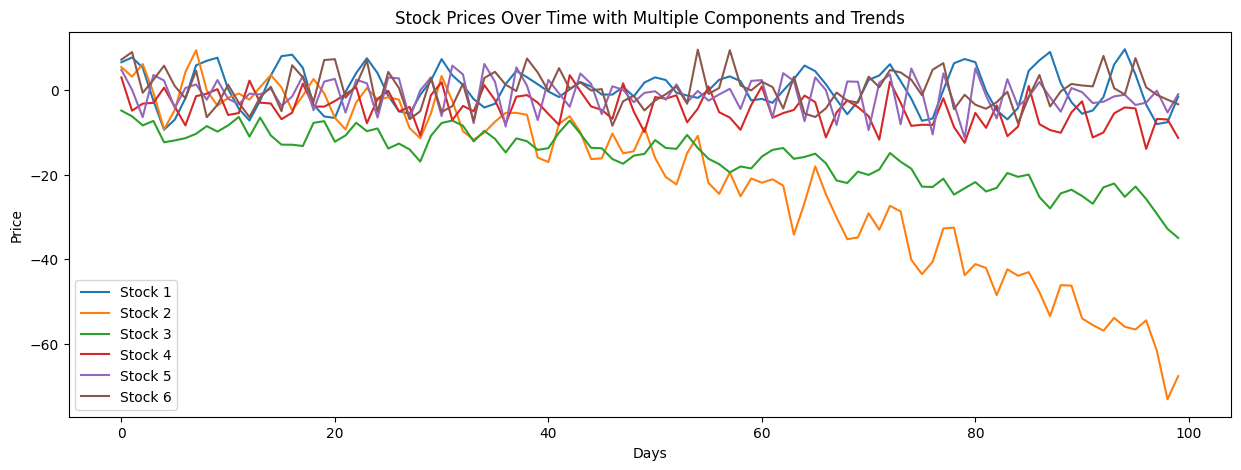

[[  6.56767545   5.4381939   -4.8630499    2.97656703   4.78870558
    7.2005181    9.52078844   6.27151803   0.41388013  -6.10768266]
 [  7.7054645    3.16251342  -6.22173907  -4.89431582   0.0702842
    8.97643573   4.65047245  -0.33586597  -9.3395451   -7.1848701 ]
 [  5.31100433   6.13737605  -8.37132154  -3.21625804  -6.41679792
   -0.65146658  -1.79538725  -4.53273566 -15.83727454 -19.05833457]
 [ -2.51444235  -0.56962994  -7.31069971  -3.03624623   3.5576907
    2.39989002  -1.63403748  -5.51577213  -8.59301103  -9.12441799]
 [ -9.38864659  -9.30273681 -12.36808711   0.55817652   2.24954224
    5.76900734  -3.17280014   4.95068777  -6.89922249 -10.03329818]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
num_days = 10000  # 天数
num_stocks = 100  # 股票数量
r = 0.3  # 相关性系数

# 设置协方差矩阵
cov_matrix = np.zeros((num_stocks, num_stocks))
for i in range(num_stocks):
    for j in range(num_stocks):
        cov_matrix[i, j] = r ** abs(i - j)

# 生成每只股票的时间序列数据
np.random.seed(0)  # 为了结果可重复
data = np.zeros((num_days, num_stocks))

def generate_stock_series(num_days, num_components, trend_type='linear'):
    """生成股票时间序列：多个波形 + 长期趋势 + 随机噪声"""
    days = np.arange(num_days)
    series = np.zeros(num_days)

    # 生成多个波形
    frequencies = np.random.uniform(0.1, 1.0, num_components)  # 不同的频率
    amplitudes = np.random.uniform(1.0, 5.0, num_components)  # 不同的幅度
    phases = np.random.uniform(0, 2 * np.pi, num_components)  # 随机相位

    for freq, amp, phase in zip(frequencies, amplitudes, phases):
        series += amp * np.sin(2 * np.pi * freq * days + phase)

    # 添加长期趋势
    if trend_type == 'linear':
        trend = np.linspace(-10, 10, num_days)
    elif trend_type == 'exponential':
        trend = np.exp(np.linspace(-1, 1, num_days))
    elif trend_type == 'polynomial':
        trend = np.poly1d(np.random.uniform(-0.01, 0.01, 3))(days)
    else:
        trend = np.zeros(num_days)

    # 添加随机噪声
    noise = np.random.normal(0, 1.0, num_days)  # 更大的噪声标准差
    series += trend + noise

    return series

# 为每只股票生成时间序列
for i in range(num_stocks):
    num_components = np.random.randint(2, 5)  # 每只股票的波形成分数量
    trend_type = np.random.choice(['linear', 'exponential', 'polynomial'])  # 随机选择长期趋势类型
    data[:, i] = generate_stock_series(num_days, num_components, trend_type)

# 通过协方差矩阵调整生成的数据
data = data @ np.linalg.cholesky(cov_matrix).T

# 可视化部分数据
plt.figure(figsize=(15, 5))
plt.plot(data[:100, :6])  # 仅绘制前10只股票的时间序列
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Stock Prices Over Time with Multiple Components and Trends')
plt.legend([f'Stock {i+1}' for i in range(10)])
plt.show()

# 输出前几行数据以验证
print(data[:5, :10])  # 打印前5天和前10只股票的数据
